# Cohort Analysis (Retention over User & Product Lifetime)

![](http://blog.appsee.com/wp-content/uploads/2018/06/action-cohort-analysis-4.png)

![](http://d35fo82fjcw0y8.cloudfront.net/2016/03/03210554/table1a2.png)

**A cohort** is a group of subjects who share a defining characteristic. We can observe how a cohort behaves across time and compare it to other cohorts. Cohorts are used in medicine, psychology, econometrics, ecology and many other areas to perform a cross-section (compare difference across subjects) at intervals through time.

**Types of cohorts:**
- **Time Cohorts** are customers who signed up for a product or service during a particular time frame. Analyzing these cohorts shows the customers’ behavior depending on the time they started using the company’s products or services. The time may be monthly or quarterly even daily.
- **Behaovior cohorts** are customers who purchased a product or subscribed to a service in the past. It groups customers by the type of product or service they signed up. Customers who signed up for basic level services might have different needs than those who signed up for advanced services. Understaning the needs of the various cohorts can help a company design custom-made services or products for particular segments.
- **Size cohorts** refer to the various sizes of customers who purchase company’s products or services. This categorization can be based on the amount of spending in some periodic time after acquisition or the product type that the customer spent most of their order amount in some period of time.


#Import Libraries and DataSet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import library
import numpy as np
import pandas as pd
import datetime as dt

#For Data  Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For Machine Learning Algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Reading Data
df = pd.read_excel('/content/drive/MyDrive/Python/Datasets/Online Retail for cohort.xlsx')



#Explore + Clean the data

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**Nots that:** There are Missing Data in `Description` and The `Customer ID` Columns , let's check that**

**Check and Clean Missing Data**

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df= df.dropna(subset=['CustomerID'])

In [7]:
df.isnull().sum().sum()

0

**Check & Clean Duplicates Data**

In [8]:
df.duplicated().sum()


5225

In [9]:
df = df.drop_duplicates()

In [10]:
df.duplicated().sum()


0

**Summary Statistics**

In [11]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


**Note That:**
* The ***min*** for `unit price` = 0 and
* the ***min*** for `Quantity` with negative value

In [12]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [13]:
df.shape

(392692, 8)

# Let's Make Cohort Analysis

**For cohort analysis, there are a few labels that we have to create:**
- **Invoice period:** A string representation of the year and month of a single transaction/invoice.
- **Cohort group:**  A string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.
- **Cohort period / Cohort Index:**  A integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.



In [14]:
def get_month(x) : return dt.datetime(x.year,x.month,1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01


In [15]:
def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day

invoice_year,invoice_month,_ = get_month_int(df,'InvoiceMonth')
cohort_year,cohort_month,_ = get_month_int(df,'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df['CohortIndex'] = year_diff * 12 + month_diff + 1

In [16]:
#Count monthly active customers from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Retention Rate Table**

In [17]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis
retention.round(3) * 100 #to show the number as percentage

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


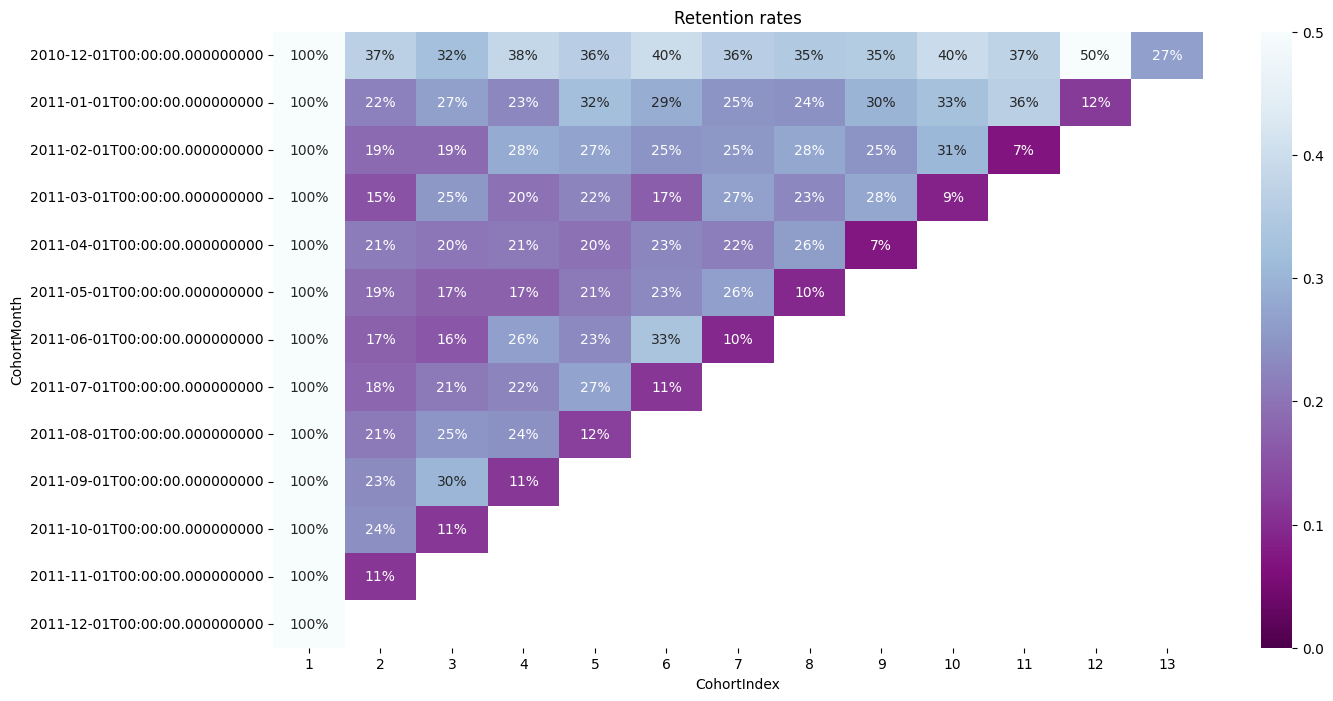

In [18]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()

**Note That:**
  * Customer retention is a very useful metric to understand how many of the all customers are still active.
  * Retention gives us the percentage of active customers compared to the total number of customers.

**Average quantity for each cohort**

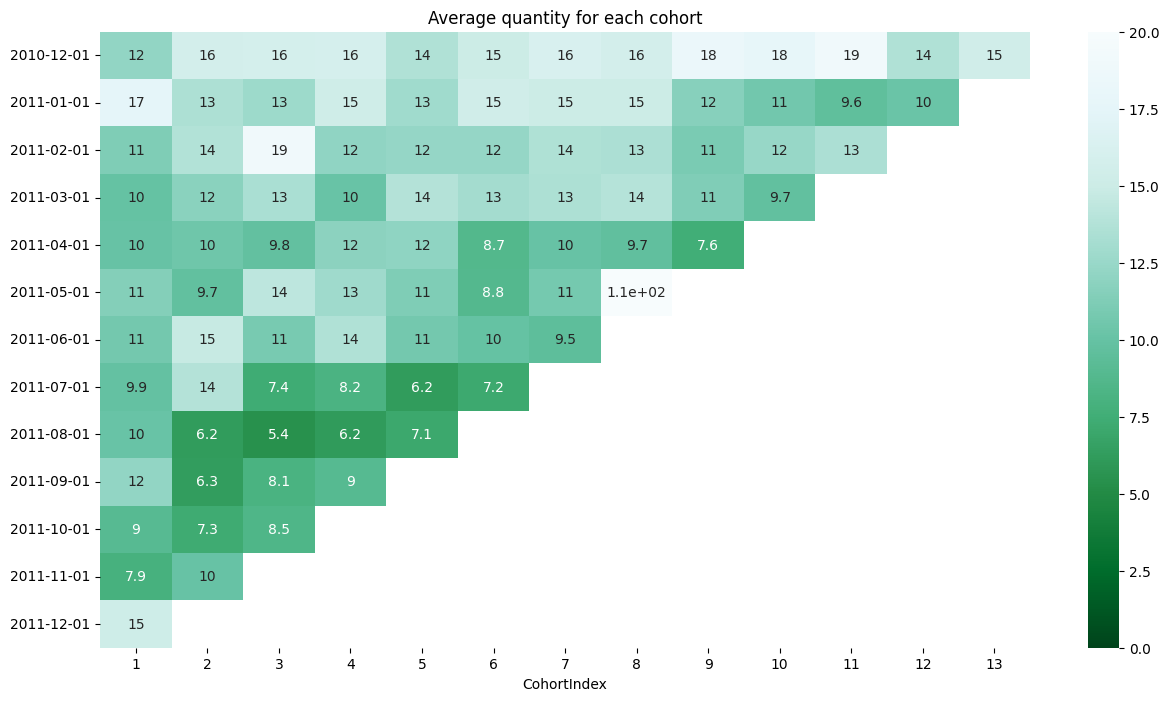

In [19]:
#Average quantity for each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Average quantity for each cohort')
sns.heatmap(data=average_quantity,annot = True,vmin = 0.0,vmax =20,cmap="BuGn_r")
plt.show()

# Recency, Frequency and Monetary Value calculation

![](http://www.omniconvert.com/blog/wp-content/uploads/2016/03/feature-img-marketizator-rfm.png)

**What is RFM?**
- **RFM** is an acronym of recency, frequency and monetary. Recency is about when was the last order of a customer. It means the number of days since a customer made the last purchase. If it’s a case for a website or an app, this could be interpreted as the last visit day or the last login time.

- **Frequency** is about the number of purchase in a given period. It could be 3 months, 6 months or 1 year. So we can understand this value as for how often or how many a customer used the product of a company. The bigger the value is, the more engaged the customers are. Could we say them as our VIP? Not necessary. Cause we also have to think about how much they actually paid for each purchase, which means monetary value.

- **Monetary** is the total amount of money a customer spent in that given period. Therefore big spenders will be differentiated with other customers such as MVP or VIP.

![](http://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png)

**The RFM values can be grouped in several ways:**
1. Percentiles e.g. quantiles
2. Pareto 80/20 cut
3. Custom - based on business knowledge

**We are going to implement percentile-based grouping.**

**Process of calculating percentiles:**
1. Sort customers based on that metric
2. Break customers into a pre-defined number of groups of equal size
3. Assign a label to each group

In [20]:
#New Total Sum Column
df['TotalSum'] = df['UnitPrice']* df['Quantity']

#Data preparation steps
print('Min Invoice Date:',df.InvoiceDate.dt.date.min(),'max Invoice Date:',
       df.InvoiceDate.dt.date.max())

df.head(3)

Min Invoice Date: 2010-12-01 max Invoice Date: 2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1,22.00


* In the real world, we would be working with the most recent snapshot of the data of today or yesterday

In [21]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date
#The last day of purchase in total is 09 DEC, 2011. To calculate the day periods,
#let's set one day after the last one,or
#10 DEC as a snapshot_date. We will cound the diff days with snapshot_date.


Timestamp('2011-12-10 12:50:00')

In [22]:
# Calculate RFM metrics
rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (snapshot_date - x.max()).days,
                                      'InvoiceNo':'count','TotalSum': 'sum'})
#Function Lambdea: it gives the number of days between hypothetical today and the last transaction

#Rename columns
rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalSum':'MonetaryValue'}
           ,inplace= True)

#Final RFM values
rfm.head()


,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


**Note That:**

* We will rate **"Recency"** customer who have been active more recently better than the less recent customer,because each company wants its customers to be recent

* We will rate **"Frequency"** and **"Monetary Value"** higher label because we want Customer to spend more money and visit more often(that is  different order than recency).

In [23]:
#Building RFM segments
r_labels =range(4,0,-1)
f_labels=range(1,5)
m_labels=range(1,5)
r_quartiles = pd.qcut(rfm['Recency'], q=4, labels = r_labels)
f_quartiles = pd.qcut(rfm['Frequency'],q=4, labels = f_labels)
m_quartiles = pd.qcut(rfm['MonetaryValue'],q=4,labels = m_labels)
rfm = rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

# Build RFM Segment and RFM Score
def add_rfm(x) : return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(add_rfm,axis=1 )
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,1.01.04.0,6
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10
12350.0,310,17,334.40,1,1,2,1.01.02.0,4


* The Result is a Table which has a row for each customer with their RFM

# Analyzing RFM Segments

**Largest RFM segments**
* It is always the best practice to investigate the size of the segments before you use them for targeting or other business Application.

In [24]:
rfm.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:5]

RFM_Segment
4.04.04.0    450
1.01.01.0    381
3.04.04.0    217
1.02.02.0    206
2.01.01.0    179
dtype: int64

**Filtering on RFM segments**

In [25]:
#Select bottom RFM segment "111" and view top 5 rows
rfm[rfm['RFM_Segment']=='111'].head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,


**Summary metrics per RFM Score**

In [26]:
rfm.groupby('RFM_Score').agg({'Recency': 'mean','Frequency': 'mean',
                             'MonetaryValue': ['mean', 'count'] }).round(1)



Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           260.7       8.2         157.4   381
4           177.2      13.6         240.0   388
5           152.9      21.2         366.6   518
6            95.9      27.9         820.8   457
7            79.6      38.0         758.1   463
8            64.1      56.0         987.3   454
9            45.9      78.7        1795.1   414
10           32.4     110.5        2056.4   426
11           21.3     186.9        4062.0   387
12            7.2     367.8        9285.9   450

**Use RFM score to group customers into Gold, Silver and Bronze segments:**

In [27]:
def segments(df):
    if df['RFM_Score'] > 9 :
        return 'Gold'
    elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 9 ):
        return 'Sliver'
    else:
        return 'Bronze'

rfm['General_Segment'] = rfm.apply(segments,axis=1)

rfm.groupby('General_Segment').agg({'Recency':'mean','Frequency':'mean',
                                    'MonetaryValue':['mean','count']}).round(1)


Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            192.2      15.1         266.5  1287
Gold               20.1     225.6        5246.8  1263
Sliver             72.0      49.4        1072.4  1788

# Data Pre-Processing for Kmeans Clustering

**We must check these Key k-means assumptions before we implement our Kmeans Clustering Mode**
- Symmetric distribution of variables (not skewed)
- Variables with same average values
- Variables with same variance

In [28]:
rfm_rfm = rfm[['Recency','Frequency','MonetaryValue']]
print(rfm_rfm.describe())



           Recency    Frequency  MonetaryValue
count  4338.000000  4338.000000    4338.000000
mean     92.536422    90.523744    2048.688081
std     100.014169   225.506968    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     306.482500
50%      51.000000    41.000000     668.570000
75%     142.000000    98.000000    1660.597500
max     374.000000  7676.000000  280206.020000


**From this table we find this Problem:**
  * Mean and Variance are not Equal

**Soluation:**
  * Scaling variables by using a scaler from scikit-learn library

<ipython-input-29-bfc33b9c4cb3>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
<ipython-input-29-bfc33b9c4cb3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
<ipython-input-29-bfc33b9c4cb3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot

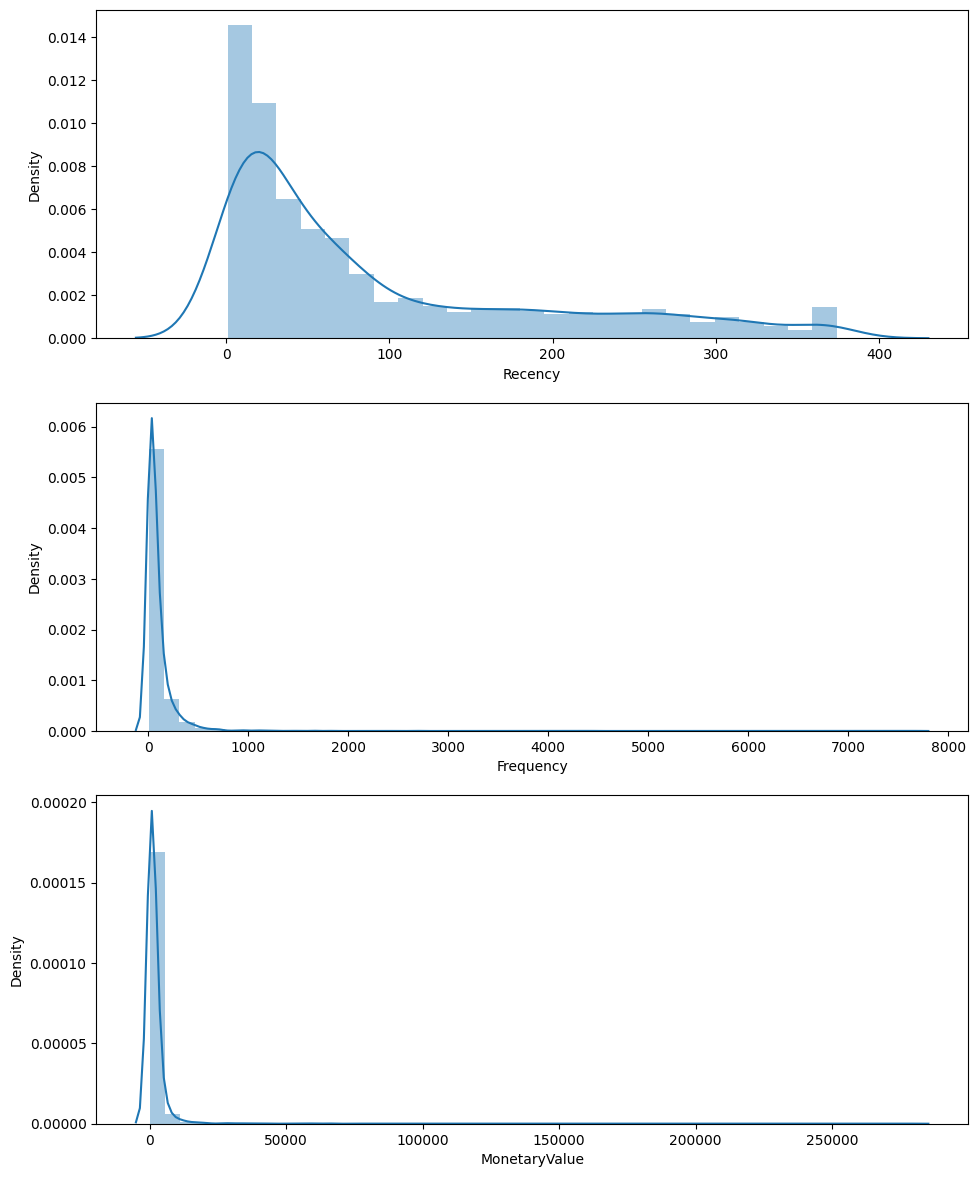

In [29]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.MonetaryValue, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()


**Also, there is another Problem:**
  * UnSymmetric distribution of variables (data skewed)

**Soluation:**
  * Logarithmic transformation (positive values only) will manage skewness

**We use these Sequence of structuring pre-processing steps:**

1. Unskew the data - log transformation

2. Standardize to the same average values

3. Scale to the same standard deviation

4. Store as a separate array to be used for clustering
_______________________________

**Why the sequence matters?**
- Log transformation only works with positive data
- Normalization forces data to have negative values and log will not work

<ipython-input-30-82a170e2bbad>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
<ipython-input-30-82a170e2bbad>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
<ipython-input-30-82a170e2bbad>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `

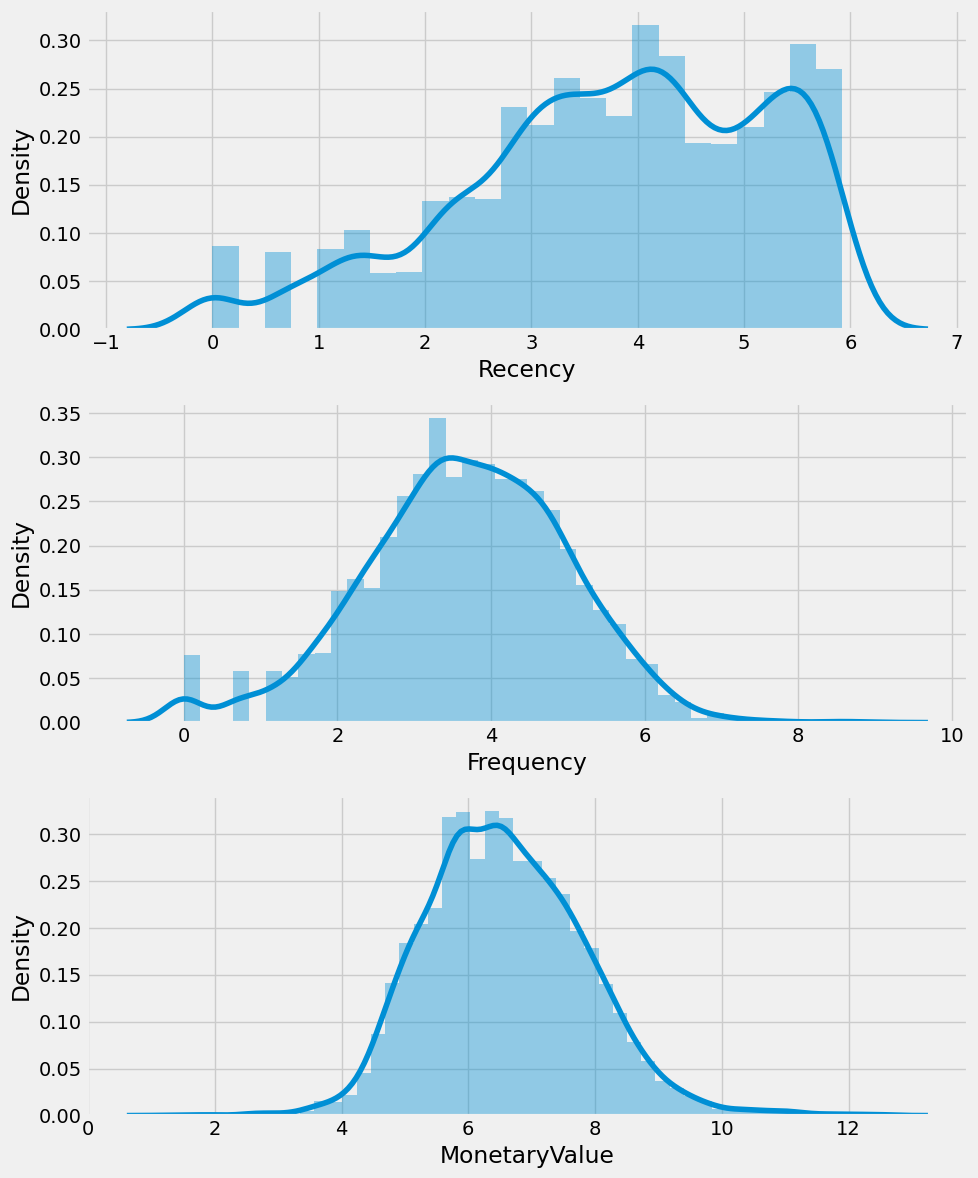

In [30]:
#Unskew the data with log transformation
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)
#or rfm_log = np.log(rfm_rfm)


# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log.MonetaryValue, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()


# Implementation of K-Means Clustering

**Key steps**
1. Data pre-processing
2. Choosing a number of clusters
3. Running k-means clustering on pre-processed data
4. Analyzing average RFM values of each cluster

**1. Data Pre-Processing**


In [31]:
#Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)
#Store it separately for clustering
rfm_normalized= scaler.transform(rfm_log)

**2. Choosing a Number of Clusters**

**Methods to define the number of clusters**
- Visual methods - elbow criterion
- Mathematical methods - silhouette coefficient
- Experimentation and interpretation

**Elbow criterion method**
- Plot the number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster center
- Identify an "elbow" in the plot
- Elbow - a point representing an "optimal" number of clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

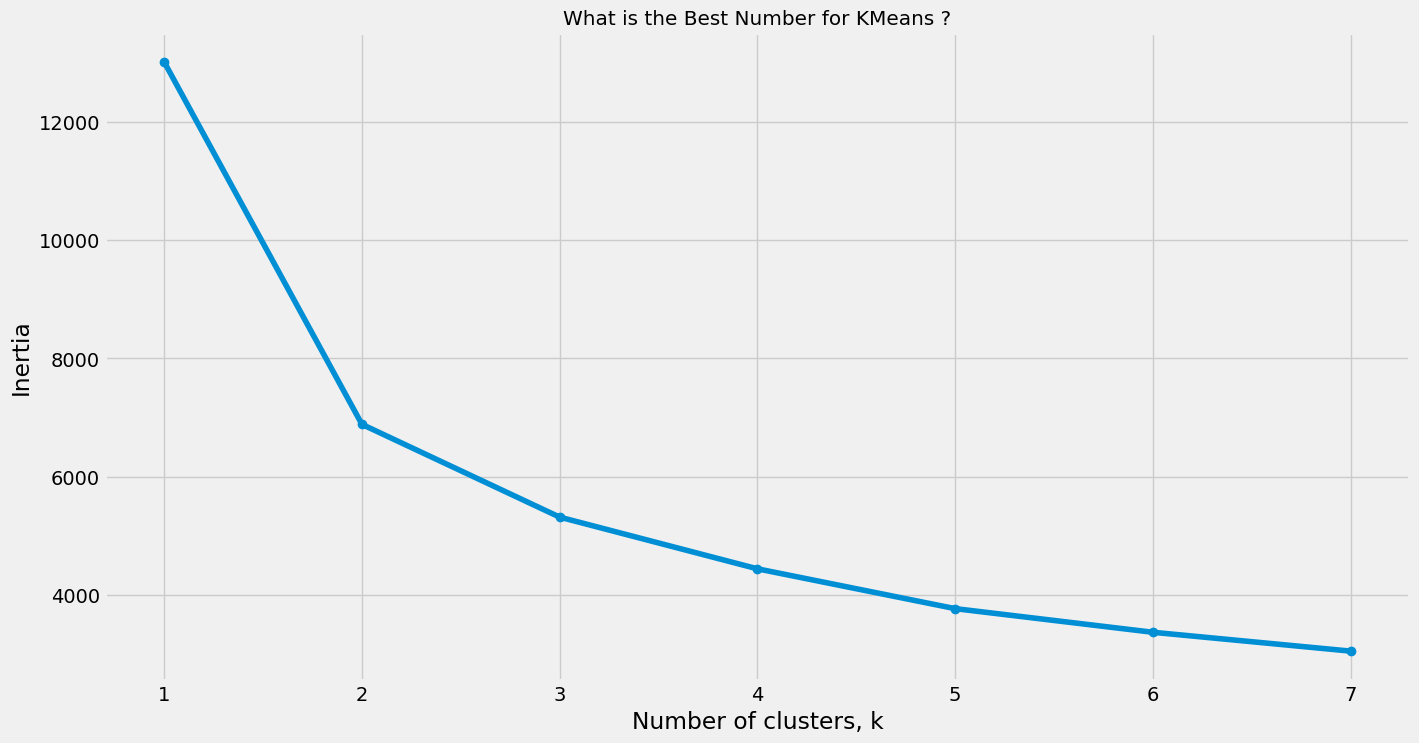

In [32]:
from sklearn.cluster import KMeans

#First : Get the Best KMeans
ks = range(1,8)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()



**Note Theat:**
  * We Choose No. of KMeans = 3

In [33]:
# clustering
kc = KMeans(n_clusters= 3, random_state=1)
kc.fit(rfm_normalized)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_rfm_k3 = rfm_rfm.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_rfm_k3.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count'],}).round(0)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0           171.0      15.0         293.0  1523
1            69.0      65.0        1167.0  1859
2            13.0     260.0        6559.0   956

**Snake plots to understand and compare segments**
- Market research technique to compare different segments
- Visual representation of each segment's attributes
- Need to first normalize data (center & scale)
- Plot each cluster's average normalized values of each attribute



In [34]:
rfm_normalized = pd.DataFrame(rfm_normalized,index=rfm_rfm.index,columns=rfm_rfm.columns)
rfm_normalized['K_Cluster'] = kc.labels_
rfm_normalized['General_Segment'] = rfm['General_Segment']
rfm_normalized.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_normalized,id_vars=['CustomerID','General_Segment','K_Cluster'],value_vars=['Recency', 'Frequency', 'MonetaryValue'],
var_name='Metric',value_name='Value')
rfm_melt.head()


,CustomerID,General_Segment,K_Cluster,Metric,Value
0,12346.0,Sliver,1,Recency,1.409982
1,12347.0,Gold,2,Recency,-2.146578
2,12348.0,Sliver,1,Recency,0.383648
3,12349.0,Gold,1,Recency,-0.574961
4,12350.0,Bronze,0,Recency,1.375072


**Snake Plot and Heatmap**

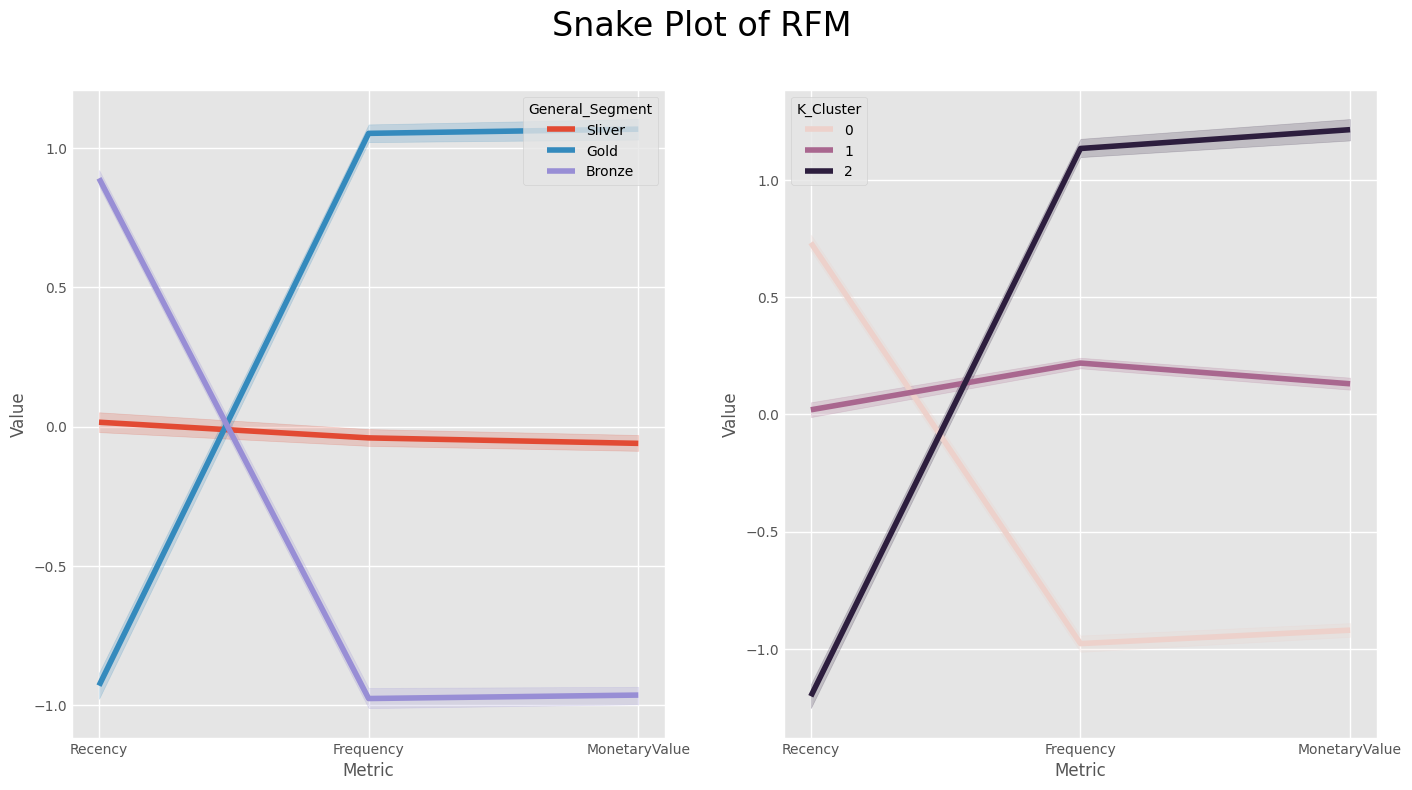

In [35]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
sns.lineplot(x = 'Metric', y = 'Value', hue = 'General_Segment', data = rfm_melt,ax=ax1)

# a snake plot with K-Means
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt,ax=ax2)

plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle
plt.show()


**Relative importance of segment attributes**
- Useful technique to identify relative importance of each segment's attribute
- Calculate average values of each cluster
- Calculate average values of population
- Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

*Let’s try again with a heat map. Heat maps are a graphical representation of data where larger values were colored in darker scales and smaller values in lighter scales. We can compare the variance between the groups quite intuitively by colors.*



In [36]:
# The further a ratio is from 0, the more important that attribute is for a segment relative to the total population
cluster_avg = rfm_rfm_k3.groupby(['K_Cluster']).mean()
population_avg = rfm_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)



,Recency,Frequency,MonetaryValue
K_Cluster,,,
0,0.85,-0.84,-0.86
1,-0.25,-0.28,-0.43
2,-0.86,1.87,2.20


In [37]:
# the mean value in total
total_avg = rfm.iloc[:, 0:3].mean()
# calculate the proportional gap with total mean
cluster_avg = rfm.groupby('General_Segment').mean().iloc[:, 0:3]
prop_rfm = cluster_avg/total_avg - 1
prop_rfm.round(2)


<ipython-input-37-10baea627ea5>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_avg = rfm.groupby('General_Segment').mean().iloc[:, 0:3]


,Recency,Frequency,MonetaryValue
General_Segment,,,
Bronze,1.08,-0.83,-0.87
Gold,-0.78,1.49,1.56
Sliver,-0.22,-0.45,-0.48


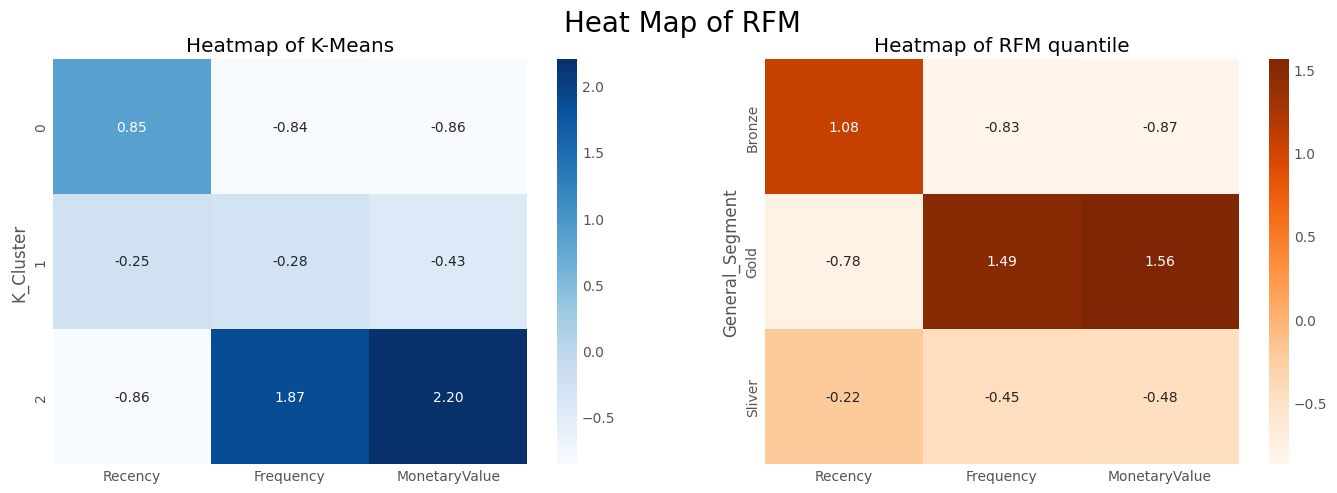

In [38]:
# heatmap with RFM
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
ax1.set(title = "Heatmap of K-Means")

# a snake plot with K-Means
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True,ax=ax2)
ax2.set(title = "Heatmap of RFM quantile")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle

plt.show()



**We can Updated RFM data by adding Tenure variable:**

* Tenure: time since the first transaction ، Defines how long the customer has been with the company

**Conclusion:**  
  * We talked about how to get RFM values from customer purchase data, and we made two kinds of segmentation with RFM quantiles and K-Means clustering methods.


